# Intial Data Investigation

Here we'll investigate both train and test raw datasets for gaining more insight into the data in order to come up with right ideas for modelling phase.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# import our modules here
from modules.DataHandler import *
from modules.utils import *

# HandleData: used for downloading dataset (txt) files and handle the data we get
datahandler = DataHandler()

## 1. Plot data

Pre-processed raw data had fixed windows of 2.56 seconds (128 data points) with a 50% overlap. For avoiding duplications due to overlapping in plotting, we'll remove overlaps and squash data frames it to the series. 

#### Load data

In [2]:
# get train data

prefix  = 'train'
X_train = datahandler.load_files('UCI HAR Dataset/{p}/Inertial Signals/'.format(p=prefix))
y_train = datahandler.load_txt('UCI HAR Dataset/{p}/y_{p}.txt'.format(p=prefix)).values

# get indices that map each (occurence) rows to their subject in the dataset
subject_mapping = datahandler.load_txt('UCI HAR Dataset/{p}/subject_{p}.txt'.format(p=prefix)).values

In [3]:
# PRINT DATA INFO

print('TRAIN\nX={}'.format(X_train.shape))
print('y={}'.format(y_train.shape))
print('activities={}'.format(np.unique(y_train)))
print('subjects={}\n'.format(np.unique(subject_mapping)))

TRAIN
X=(7352, 128, 9)
y=(7352, 1)
activities=[1 2 3 4 5 6]
subjects=[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]



### 1.1 Plot time series of each inertial signals for a given subject

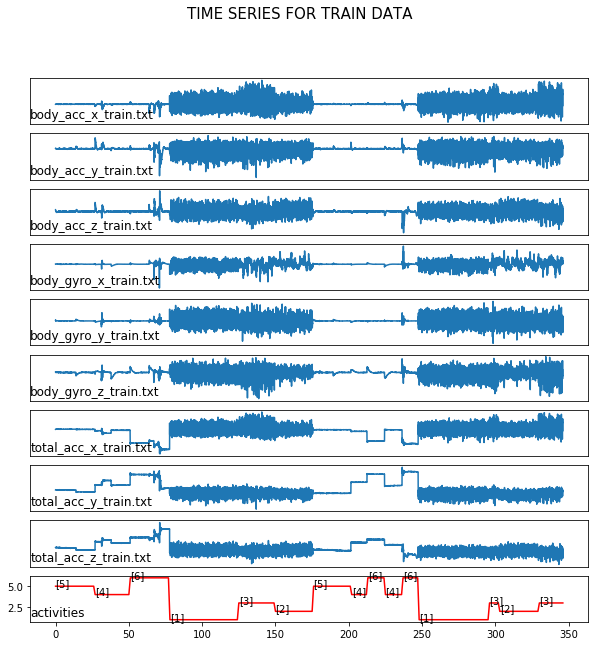

In [4]:
def plot_time_series(data, target_data, subject_mapping, subject_id, signal_names, title):
    
    '''
    inputs:
        data: data (X) with the size of NxMxK, where
              N=obervation, M=series, K=features (number of inertial signals),
        traget_data: target data (y) contains labelled activities.
        subject_mapping: indices that map each (occurence) rows to their subject in the dataset
        subject_id: subject id we'll use we extracting subdata 
        signal_names: name of inertial signals (name of this K features).
        title: tiel for plot
        
    output: plot the time series
    '''
    # HANDLE DATA
    # retrive all observations (rows) for a given subject id
    sub_data = data[subject_mapping[:,0]==subject_id]
    sub_target_data = target_data[subject_mapping[:, 0]==subject_id]
    # remove overlap
    sub_data = datahandler.remove_overlap(sub_data)
    
    # PLOT
    # create a subplot
    fig, ax = plt.subplots(nrows=len(signal_names)+1, ncols=1, figsize=(10,10), squeeze=True)

    # iterate over each signal
    for i in range(len(signal_names)):
        # add time series of corresponding inertial signal values
        ax[i].plot(sub_data[:, i])
        ax[i].set_title(signal_names[i], y=0, loc='left')
        # make axes unvisible
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)

    # add activity values to last ax
    ax[-1].plot(sub_target_data, 'r')
    ax[-1].set_title('activities', y=0, loc='left')
    
    # annotate activity number when there is a change
    temp_activity = 0
    for idx, activity in enumerate(sub_target_data): 
        if temp_activity!=activity: 
            temp_activity=activity
            ax[-1].annotate(str(activity), xy=(idx, activity))
    
    # add title and show plot
    fig.suptitle(title.upper(), fontsize=15)
    plt.show()
    
    
# get signal names 
signal_names = os.listdir('UCI HAR Dataset/train/Inertial Signals/')
# plot raw data 
plot_time_series(X_train, y_train, subject_mapping, 1, signal_names, 'time series for train data')

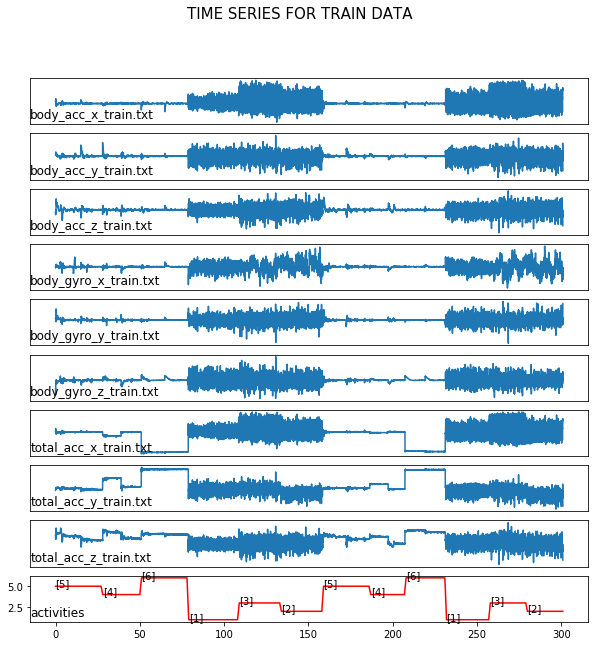

In [5]:
plot_time_series(X_train, y_train, subject_mapping, 5, signal_names, 'time series for train data')

As it's clear from the in the plot, periods with large fluctuations in sensor value correspond to walking activities (1: walking, 2: walking upstairs, 3: walking downstairs). On the contrary, periods with fewer activity periods account for stationary activities (4: sitting, 5: standing, 6: laying). However, distribution of data for activities of same movement groups is similar to each other, waking and stationary groups. This gives the idea that the raw feature can be helpful for classifying at least between walking activities and stationary activities. Yet, it also seems that, on the contrary to other inertial signals, total acceleration data on each axis can also be important for discriminating activities within the stationary group as it shows distinctive distribution upon activities of the same group. For a more detailed look, in the next step, we'll take a look at the histograms of each inertial signal per activity.

### 1.2 Plot histogram of each inertial signals per the activity

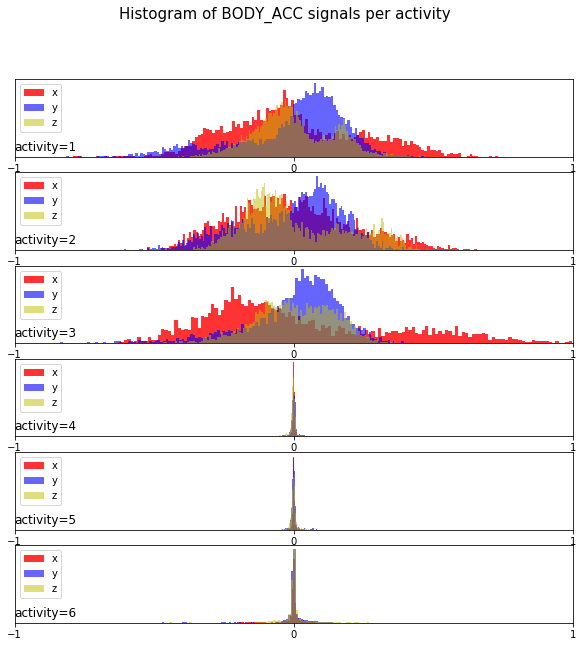

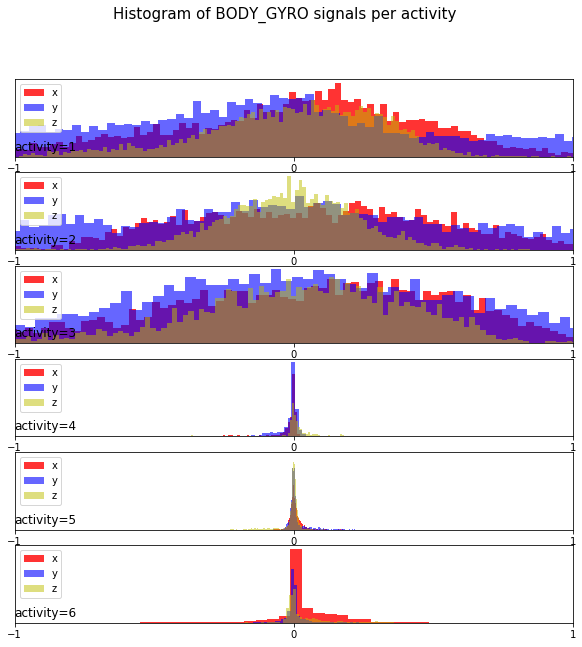

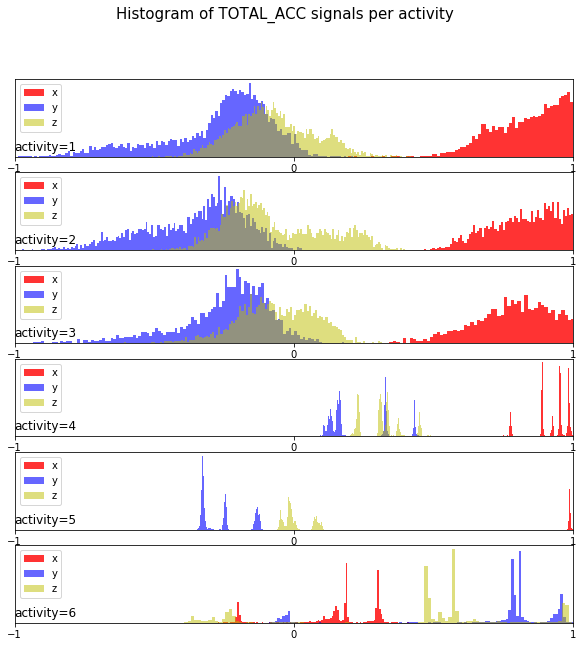

In [6]:
def plot_activity_histogram(data, target_data, subject_mapping, subject_id, signal_names):
    
    '''
    inputs:
        data: data (X) with the size of NxMxK, where 
              N=obervation, M=series, K=features (number of inertial signals),
        traget_data: target data (y) contains labelled activities.
        subject_mapping: indices that map each (occurence) rows to their subject in the dataset
        subject_id: subject id we'll use we extracting subdata 
        signal_names: name of inertial signals (name of these K features).

    output: plot the activity histogram per activity per user
    '''
    # HANDLE DATA
    # retrive all observations (rows) for a given subject id
    data = data[subject_mapping[:,0]==subject_id]
    target_data = target_data[subject_mapping[:, 0]==subject_id]
    
    
    # iterate over signals by 3, becase for each signal type we have 3 differnet axes values
    for s_name in range(0, len(signal_names), 3):

        # get signal name
        _t_indx = signal_names[s_name].find('_t')
        signal = signal_names[s_name][:_t_indx-2]
        
        # greate a subplot for the signal type
        fig, ax = plt.subplots(nrows=len(np.unique(target_data)), ncols=1, figsize=(10,10), squeeze=True)
        
        # iterate over each activity
        for activity in np.unique(target_data):

            # HANDLE DATA
            # retrive all observations (rows) for a given activity
            sub_data = data[target_data[:,0]==activity]
            sub_target_data = target_data[target_data[:, 0]==activity]
            
            # remove overlap
            sub_data = datahandler.remove_overlap(sub_data)

            # PLOT
            # add x,y,z data to histogram
            ax[activity-1].hist(sub_data[:,s_name], bins=150, alpha = 0.8, color='r', label='x')
            ax[activity-1].hist(sub_data[:,s_name+1], bins=150, alpha = 0.6, color='b', label='y')
            ax[activity-1].hist(sub_data[:,s_name+2], bins=150, alpha = 0.5, color='y', label='z')
    
            # add title and legend
            ax[activity-1].set_title("activity={}".format(activity), y=0, loc='left')
            ax[activity-1].legend(loc='upper left')
            
            # simplify axes
            ax[activity-1].get_yaxis().set_visible(False)
            ax[activity-1].set_xlim(-1,1)
            ax[activity-1].set_xticks([-1,0,1])
            
        # add fig title and show plot
        fig.suptitle("Histogram of {} signals per activity".format(signal.upper()), fontsize=15)
        plt.show()
        
        
plot_activity_histogram(X_train, y_train, subject_mapping, 1, signal_names)

Above histograms summarise the body acceleration and gyroscope data show a very similar distributions (all of them being normal and overlapping) for the sensor data across the activities. However, it's clear that the total acceleration values don't follow a normal distribution. Although there is still overlapping among the walking activities, for stationary activities, we can see that they don't overlap, thus, they can be deterministic. What we see now proves the insights we had after ploting time series. Ineed, it's clear that total acceleration data will be important for modelling.